In [1]:
# import time libraries
import time
from datetime import datetime
from time import gmtime, strftime

# Set Begin Time to Measure Time to Run of Whole Notebook
begin_time = time.time()

#### CoreLogic Interview
#### Lending Club Data

#### Purpose of the Data
* Assess profitability for the dataset provided by Lending Club to Kaggle in order to demonstrate expertise in Credit Risk, Predictive Modeling, and aptitude working with Credit Bureau data.
* Lending Club allows investors to purchase loans they originate with as little as $1,000.  They also provide a number of tax advantaged options for investing including 401ks, IRAs, Trust Accounts, etc.
    * Information about Lending Club loans available for purchase at 
* Using the data provided on Kaggle, investigate the feasability of cherry picking the loans with the highest Risk Adjusted Margin.
* Data available at https://www.lendingclub.com/info/download-data.action
    * To get all fields including FICO, you need to signup for a Lending Club account, otherwise some fields will be missing.
    * No alterations to the .csv files need to be made,  however the files need to be unzipped.
* Additional information for prospective individual investors can be found at https://www.lendingclub.com/public/rates-and-fees.action

* This analysis was performed with stock Anaconda, however the below packages may need to be updated.
    * conda install -c conda-forge/label/gcc7 eli5
    * conda install -c anaconda py-xgboost
    * conda install -c conda-forge matplotlib
    * conda install -c conda-forge seaborn

In [2]:
## Pull Relavent Libraries

# Standard Libraries
import pandas as pd
import numpy as np
import os
import math
import requests
from io import StringIO
#from StringIO import StringIO
import sys
import os.path
from IPython.display import display, HTML

# For Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Other
import scipy
from scipy.stats import norm, skew #for some statistics
from scipy.special import boxcox1p
from datetime import timedelta

# Import Functions Built
from Functions import countplotshorizontal, null_values, histogram, stacked_bar, anova
from Functions import spearman_df, spearman_chart, spearman_df_abs, spearman_chart_abs, encode

# Set Notebook Options
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

#### View the Data Dictionary
* We can use this later to view definitions of features.

In [3]:
os.chdir(sys.path[0] + '\\Data')
# os.chdir('C:\\Users\\apost\\Desktop\\Python\\CL\\LendingClub\\Data')

xls = pd.ExcelFile('LCDataDictionary.xlsx')

DataDict1 = pd.read_excel(xls, 'LoanStats')
DataDict2 = pd.read_excel(xls, 'browseNotes')
DataDict3 = pd.read_excel(xls, 'RejectStats')

DataDict1.columns = ['Variable', 'Description']
DataDict2.columns = ['Variable', 'Description']
DataDict3.columns = ['Variable', 'Description']

DataDict = pd.concat([DataDict1, DataDict2, DataDict3])

pd.set_option('display.max_colwidth', -1)
display(HTML(DataDict[0:5].to_html()))
display(HTML(DataDict.tail().to_html()))

### Read in the Data

In [4]:
%%time

FileList = ['LoanStats3a_securev1','LoanStats3b_securev1','LoanStats3c_securev1','LoanStats3d_securev1',
            'LoanStats_securev1_2016Q1','LoanStats_securev1_2016Q2','LoanStats_securev1_2016Q3','LoanStats_securev1_2016Q4',
            'LoanStats_securev1_2017Q1','LoanStats_securev1_2017Q2','LoanStats_securev1_2017Q3','LoanStats_securev1_2017Q4',
            'LoanStats_securev1_2018Q1','LoanStats_securev1_2018Q2','LoanStats_securev1_2018Q3']

# First row of the CSVs contained an url w/ txt, remove that
df00 = pd.read_csv(FileList[0] + '.csv', skiprows = 1, low_memory = False)
df01 = pd.read_csv(FileList[1] + '.csv', skiprows = 1, low_memory = False)
df02 = pd.read_csv(FileList[2] + '.csv', skiprows = 1, low_memory = False)
df03 = pd.read_csv(FileList[3] + '.csv', skiprows = 1, low_memory = False)
df04 = pd.read_csv(FileList[4] + '.csv', skiprows = 1, low_memory = False)
df05 = pd.read_csv(FileList[5] + '.csv', skiprows = 1, low_memory = False)
df06 = pd.read_csv(FileList[6] + '.csv', skiprows = 1, low_memory = False)
df07 = pd.read_csv(FileList[7] + '.csv', skiprows = 1, low_memory = False)
df08 = pd.read_csv(FileList[8] + '.csv', skiprows = 1, low_memory = False)
df09 = pd.read_csv(FileList[9] + '.csv', skiprows = 1, low_memory = False)
df10 = pd.read_csv(FileList[10] + '.csv', skiprows = 1, low_memory = False)
df11 = pd.read_csv(FileList[11] + '.csv', skiprows = 1, low_memory = False)
df12 = pd.read_csv(FileList[12] + '.csv', skiprows = 1, low_memory = False)
df13 = pd.read_csv(FileList[13] + '.csv', skiprows = 1, low_memory = False)
df14 = pd.read_csv(FileList[14] + '.csv', skiprows = 1, low_memory = False)

df00['file'] = FileList[0]
df01['file'] = FileList[1]
df02['file'] = FileList[2]
df03['file'] = FileList[3]
df04['file'] = FileList[4]
df05['file'] = FileList[5]
df06['file'] = FileList[6]
df07['file'] = FileList[7]
df08['file'] = FileList[8]
df09['file'] = FileList[9]
df10['file'] = FileList[10]
df11['file'] = FileList[11]
df12['file'] = FileList[12]
df13['file'] = FileList[13]
df14['file'] = FileList[14]

ColumnList00 = list(df00.columns.values)
ColumnList01 = list(df01.columns.values)
ColumnList02 = list(df02.columns.values)
ColumnList03 = list(df03.columns.values)
ColumnList04 = list(df04.columns.values)
ColumnList05 = list(df05.columns.values)
ColumnList06 = list(df06.columns.values)
ColumnList07 = list(df07.columns.values)
ColumnList08 = list(df08.columns.values)
ColumnList09 = list(df09.columns.values)
ColumnList10 = list(df10.columns.values)
ColumnList11 = list(df11.columns.values)
ColumnList12 = list(df12.columns.values)
ColumnList13 = list(df13.columns.values)
ColumnList14 = list(df14.columns.values)

Wall time: 1min 11s


In [5]:
df_ColumnList = pd.DataFrame(data = {'00': ColumnList00, '01': ColumnList01, '02': ColumnList02, '03': ColumnList03, '04': ColumnList04,
                                     '05': ColumnList05, '06': ColumnList06, '07': ColumnList07, '08': ColumnList08, '09': ColumnList09,
                                     '10': ColumnList10, '11': ColumnList11, '12': ColumnList12, '13': ColumnList13, '14': ColumnList14})

In [6]:
display(HTML(df_ColumnList[0:5].to_html()))
display(HTML(df_ColumnList.tail().to_html()))

#### Confirm all rows match across columns

In [7]:
count = 0

for r in range(0, len(df_ColumnList)):
    for c in range(1, len(df_ColumnList.columns)):
        if df_ColumnList.iloc[r][c] == df_ColumnList.iloc[r][c - 1]:
            count = count + 0
        else:
            count = count + 1            
count

0

#### All of the column names appear to be the same for each dataset, so we can concatenate
* 'url' and 'desc' don't contain any useful information so should be deleted.

In [8]:
frames = [df00[ColumnList00], df01[ColumnList00], df02[ColumnList00], df03[ColumnList00], df04[ColumnList00],
          df05[ColumnList00], df06[ColumnList00], df07[ColumnList00], df08[ColumnList00], df09[ColumnList00],
          df10[ColumnList00], df11[ColumnList00], df12[ColumnList00], df13[ColumnList00], df14[ColumnList00]]
df = pd.concat(frames)
del df['url']
del df['desc']
df['count'] = 1

display(HTML(df.head().to_html()))
display(HTML(df.tail().to_html()))

### The tail showed some bad data, these are where the CSVs had some additional rows with text, let's remove those

In [9]:
df = df[df.id.apply(lambda x: x.isnumeric())]
display(HTML(df.tail().to_html()))

#### Convert the dates into a more workable format
* This step takes a while, so we run before saving the DataFrame

In [10]:
%%time

DateList = ['issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d']

for i in range(0, len(DateList)):
    df[DateList[i]] = pd.to_datetime(df[DateList[i]])

Wall time: 3min 43s


#### Create a Variable for Quarter

In [11]:
df['str_date'] = df['issue_d'].apply(lambda x: x.strftime('%d%m%Y'))
df['Year'] = df['str_date'].str[4:8]
df['Month'] = df['str_date'].str[2:4]
df['YearMonth'] = df['issue_d'].apply(lambda x: x.strftime('%Y%m'))
df['Qtr'] = df['Month'].copy(deep = True)
df['Qtr'] = df['Qtr'].replace(['01', '02', '03'], '01')
df['Qtr'] = df['Qtr'].replace(['04', '05', '06'], '02')
df['Qtr'] = df['Qtr'].replace(['07', '08', '09'], '03')
df['Qtr'] = df['Qtr'].replace(['10', '11', '12'], '04')
df['YearQtr'] = df['Year'] + df['Qtr']

In [12]:
df2 = df.copy(deep = True)
df2 = pd.DataFrame(df2.groupby(['issue_d', 'YearQtr'], axis = 0)['count'].sum())
df2 = df2.reset_index(level = 'YearQtr', col_level = 0)
df2 = df2.reset_index(level = 'issue_d', col_level = 0)
df2.to_dense().to_csv("df2.csv", index = False, sep = ',', encoding = 'utf-8')

In [13]:
# Save the DataFrame
df.to_pickle('df0.pkl')

In [14]:
# Read Back in the DataFrame
df = pd.read_pickle('df0.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2132256 entries, 0 to 128193
Columns: 157 entries, id to YearQtr
dtypes: datetime64[ns](4), float64(111), int64(1), object(41)
memory usage: 2.5+ GB


### View the statuses of the loans.
* Below we can see that there's a large number of "Current" Status loans in the datasets.  We need to isolate to only Matured loans for this analysis.  A mature loan includes:
    * Paid in Full
    * Prepaid
    * Charged Off

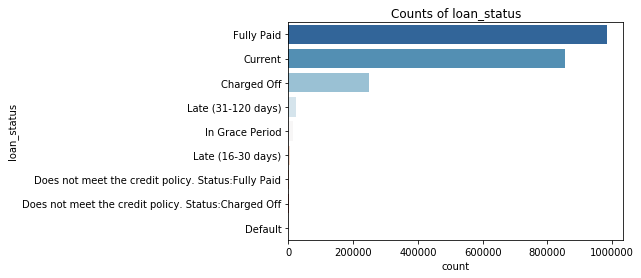

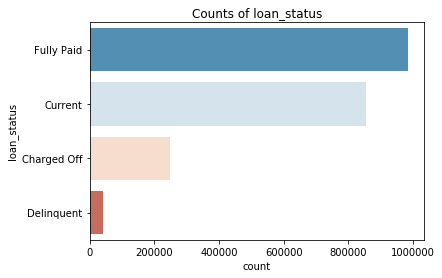

In [15]:
countplotshorizontal(frame = df, field = 'loan_status', title = "Counts of " + 'loan_status', ylabel = 'loan_status', palette = "RdBu_r")

# Cleanup Statuses

df['loan_status'] = np.where(df['loan_status'] == 'Late (31-120 days)', 'Delinquent', df['loan_status'])
df['loan_status'] = np.where(df['loan_status'] == 'Late (16-30 days)', 'Delinquent', df['loan_status'])
df['loan_status'] = np.where(df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid', 'Fully Paid', df['loan_status'])
df['loan_status'] = np.where(df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off', 'Charged Off', df['loan_status'])
df['loan_status'] = np.where(df['loan_status'] == 'Default', 'Charged Off', df['loan_status'])
df['loan_status'] = np.where(df['loan_status'] == 'In Grace Period', 'Delinquent', df['loan_status'])

## Isolate to only matured loans
# df = df[(df['loan_status'] == 'Fully Paid') | (df['loan_status'] == 'Charged Off')]

countplotshorizontal(frame = df, field = 'loan_status', title = "Counts of " + 'loan_status', ylabel = 'loan_status', palette = "RdBu_r")

### Check mix of status by Vintage
* Since the files contained different vintages, check to see if the newer vintages have an imbalance in matured loans.  The newer vintages are likely biased towards having more charges offs than fully paid since charge offs happen quicker.

In [16]:
## Group By Month

df_Mth1 = pd.DataFrame(df.groupby(['issue_d', 'loan_status'], axis = 0)['count'].sum())
df_Mth1 = df_Mth1.reset_index(level = 'issue_d', col_level = 0)
df_Mth1 = df_Mth1.reset_index(level = 'loan_status', col_level = 0)

df_Mth2 = pd.DataFrame(df.groupby(['issue_d'], axis = 0)['count'].sum())
df_Mth2['loan_status'] = 'total'
df_Mth2 = df_Mth2.reset_index(level = 'issue_d', col_level = 0)

df_Mth3 = pd.merge(df_Mth1, df_Mth2, how = 'left', left_on = 'issue_d', right_on = 'issue_d', copy = True)
del df_Mth3['loan_status_y']

df_Mth3 = df_Mth3.rename(columns = {'loan_status_x': 'loan_status', 'count_x': 'count', 'count_y': 'total', 'issue_d': 'date'})
df_Mth3['pct'] = (df_Mth3['count'] / df_Mth3['total']) * 100
# df_Mth3 = df_Mth3.loc[dfTemp3['loan_status'] == 'Charged Off']
df_Mth3 = df_Mth3.set_index('date')

df_Mth4 = df_Mth3.reset_index(drop = False)

# Convert to String
df_Mth4['YearMonth'] = df_Mth4['date'].apply(lambda x: x.strftime('%Y%m'))

display(HTML(df_Mth4[0:10].to_html()))
display(HTML(df_Mth4[-8:].to_html()))

In [17]:
## Group By Quarter

df_Qtr1 = pd.DataFrame(df.groupby(['YearQtr', 'loan_status'], axis = 0)['count'].sum())
df_Qtr1 = df_Qtr1.reset_index(level = 'YearQtr', col_level = 0)
df_Qtr1 = df_Qtr1.reset_index(level = 'loan_status', col_level = 0)

df_Qtr2 = pd.DataFrame(df.groupby(['YearQtr'], axis = 0)['count'].sum())
df_Qtr2['loan_status'] = 'total'
df_Qtr2 = df_Qtr2.reset_index(level = 'YearQtr', col_level = 0)

df_Qtr3 = pd.merge(df_Qtr1, df_Qtr2, how = 'left', left_on = 'YearQtr', right_on = 'YearQtr', copy = True)
del df_Qtr3['loan_status_y']

df_Qtr3 = df_Qtr3.rename(columns = {'loan_status_x': 'loan_status', 'count_x': 'count', 'count_y': 'total'})
df_Qtr3['pct'] = (df_Qtr3['count'] / df_Qtr3['total']) * 100
# df_Qtr3 = df_Qtr3.loc[dfTemp3['loan_status'] == 'Charged Off']
df_Qtr3 = df_Qtr3.set_index('YearQtr')

df_Qtr4 = df_Qtr3.reset_index(drop = False)

display(HTML(df_Qtr4[0:10].to_html()))
display(HTML(df_Qtr4[-8:].to_html()))

In [18]:
## Create Lists for Graphing

df_Mth_Date = pd.DataFrame(df_Mth4['YearMonth'].unique(), columns = ['YearMonth'])

df_Mth_FP = df_Mth4[(df_Mth4['loan_status'] == 'Fully Paid')]
df_Mth_FP = pd.merge(df_Mth_Date, df_Mth_FP, how = 'left', left_on = 'YearMonth', right_on = 'YearMonth', copy = False)

df_Mth_CO = df_Mth4[(df_Mth4['loan_status'] == 'Charged Off')]
df_Mth_CO = pd.merge(df_Mth_Date, df_Mth_CO, how = 'left', left_on = 'YearMonth', right_on = 'YearMonth', copy = False)

df_Mth_DQ = df_Mth4[(df_Mth4['loan_status'] == 'Delinquent')]
df_Mth_DQ = pd.merge(df_Mth_Date, df_Mth_DQ, how = 'left', left_on = 'YearMonth', right_on = 'YearMonth', copy = False)

df_Mth_Cu = df_Mth4[(df_Mth4['loan_status'] == 'Current')]
df_Mth_Cu = pd.merge(df_Mth_Date, df_Mth_Cu, how = 'left', left_on = 'YearMonth', right_on = 'YearMonth', copy = False)

list_Mth_dates = df_Mth_Date['YearMonth'].tolist()
list_Mth_FP = df_Mth_FP['count'].fillna(0).astype(int).tolist()
list_Mth_CO = df_Mth_CO['count'].fillna(0).astype(int).tolist()
list_Mth_DQ = df_Mth_DQ['count'].fillna(0).astype(int).tolist()
list_Mth_Cu = df_Mth_Cu['count'].fillna(0).astype(int).tolist()

In [19]:
print(plt.style.available)

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test']


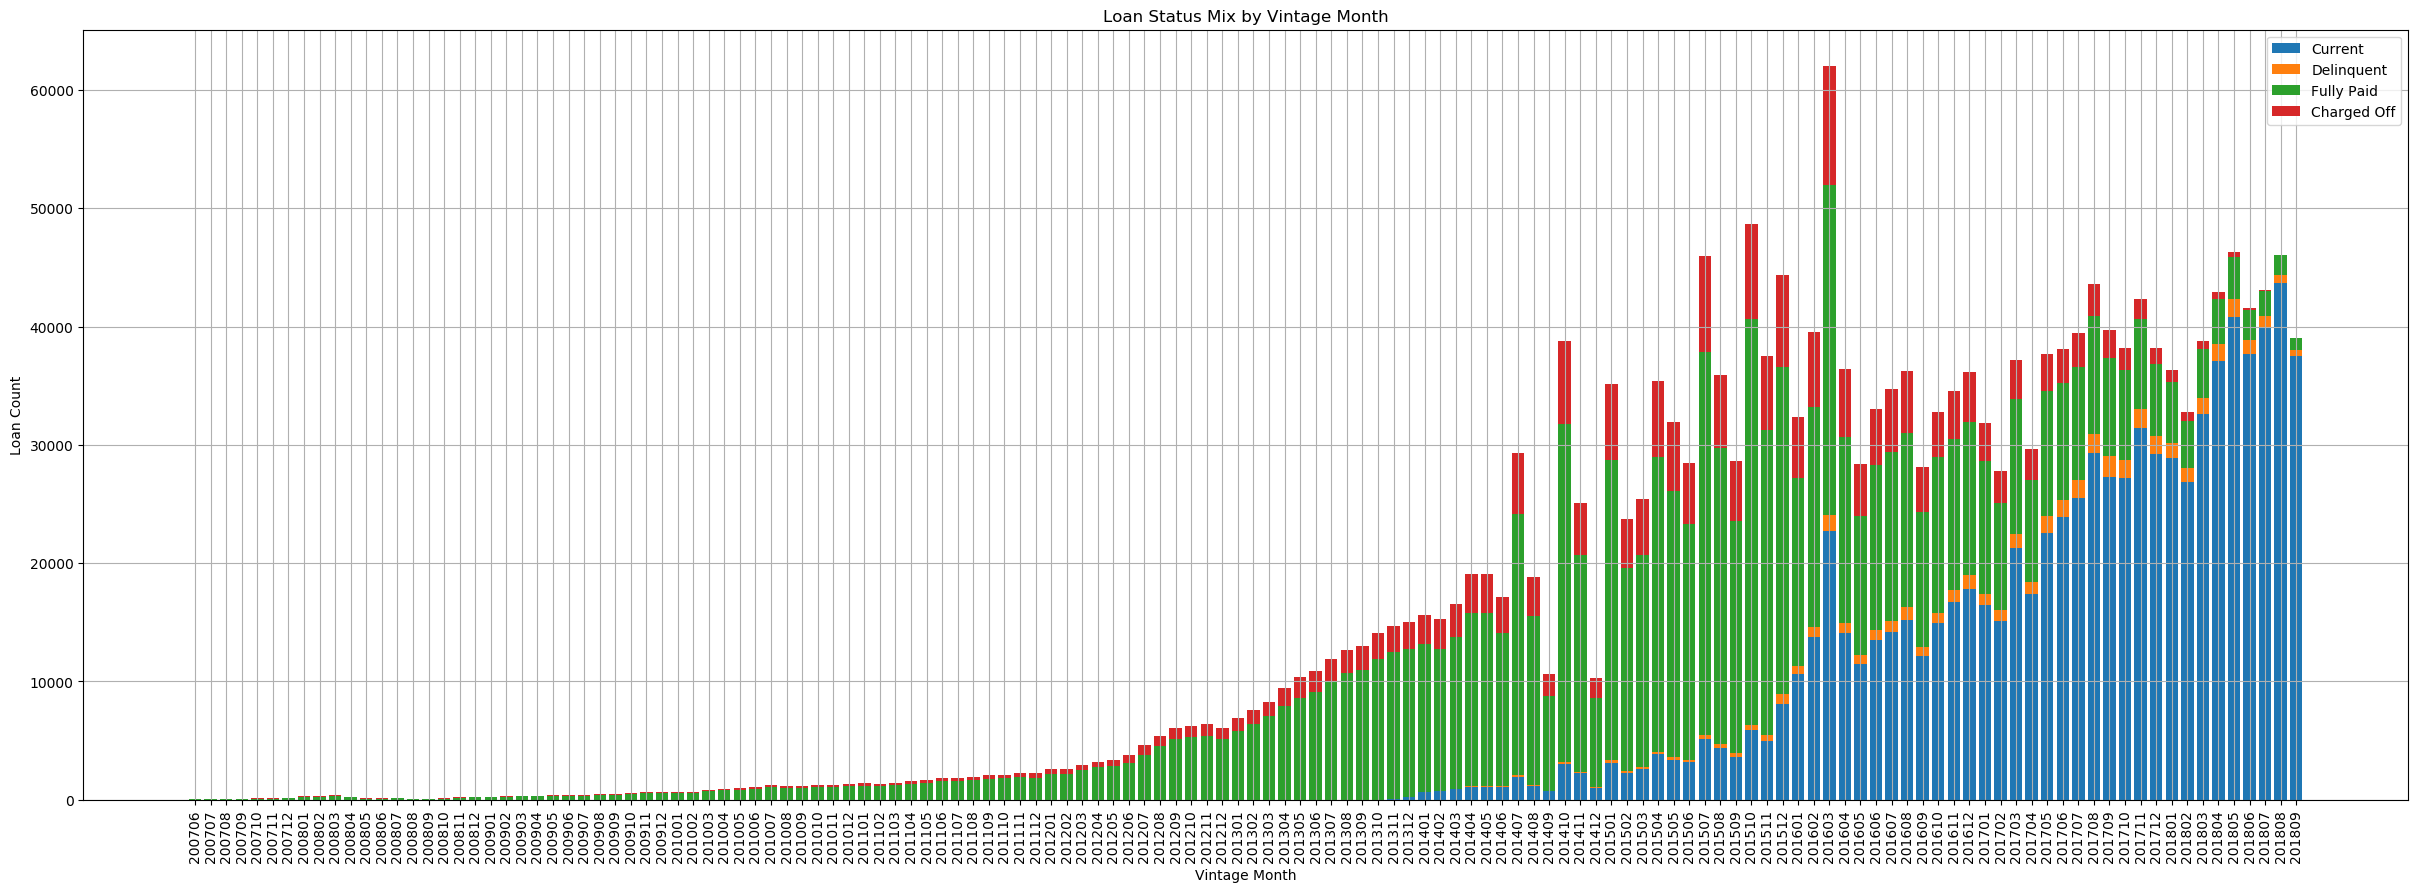

In [20]:
with plt.style.context(('default')):

    plt.figure(figsize = (30, 10))
    series_labels = ['Current', 'Delinquent', 'Fully Paid', 'Charged Off']
    data = [list_Mth_Cu, list_Mth_DQ, list_Mth_FP, list_Mth_CO]
    category_labels = list_Mth_dates

    stacked_bar(data,
                series_labels,
                category_labels = category_labels,
                show_values = False, 
                value_format = "{:.2f}",
                y_label = "Loan Count",
                x_label = 'Vintage Month',
                ch_title = 'Loan Status Mix by Vintage Month')
    plt.savefig('bar_mth1.png')
    
plt.show();

In [21]:
## Create Lists for Graphing

df_Qtr_Date = pd.DataFrame(df_Qtr4['YearQtr'].unique(), columns = ['YearQtr'])

df_Qtr_FP = df_Qtr4[(df_Qtr4['loan_status'] == 'Fully Paid')]
df_Qtr_FP = pd.merge(df_Qtr_Date, df_Qtr_FP, how = 'left', left_on = 'YearQtr', right_on = 'YearQtr', copy = False)
df_Qtr_CO = df_Qtr4[(df_Qtr4['loan_status'] == 'Charged Off')]
df_Qtr_CO = pd.merge(df_Qtr_Date, df_Qtr_CO, how = 'left', left_on = 'YearQtr', right_on = 'YearQtr', copy = False)
df_Qtr_DQ = df_Qtr4[(df_Qtr4['loan_status'] == 'Delinquent')]
df_Qtr_DQ = pd.merge(df_Qtr_Date, df_Qtr_DQ, how = 'left', left_on = 'YearQtr', right_on = 'YearQtr', copy = False)
df_Qtr_Cu = df_Qtr4[(df_Qtr4['loan_status'] == 'Current')]
df_Qtr_Cu = pd.merge(df_Qtr_Date, df_Qtr_Cu, how = 'left', left_on = 'YearQtr', right_on = 'YearQtr', copy = False)

list_Qtr_dates = df_Qtr_Date['YearQtr'].tolist()

list_Qtr_FP = df_Qtr_FP['count'].fillna(0).astype(int).tolist()
list_Qtr_CO = df_Qtr_CO['count'].fillna(0).astype(int).tolist()
list_Qtr_DQ = df_Qtr_DQ['count'].fillna(0).astype(int).tolist()
list_Qtr_Cu = df_Qtr_Cu['count'].fillna(0).astype(int).tolist()

list_Qtr_FP_pct = df_Qtr_FP['pct'].fillna(0.0).tolist()
list_Qtr_CO_pct = df_Qtr_CO['pct'].fillna(0.0).tolist()
list_Qtr_DQ_pct = df_Qtr_DQ['pct'].fillna(0.0).tolist()
list_Qtr_Cu_pct = df_Qtr_Cu['pct'].fillna(0.0).tolist()

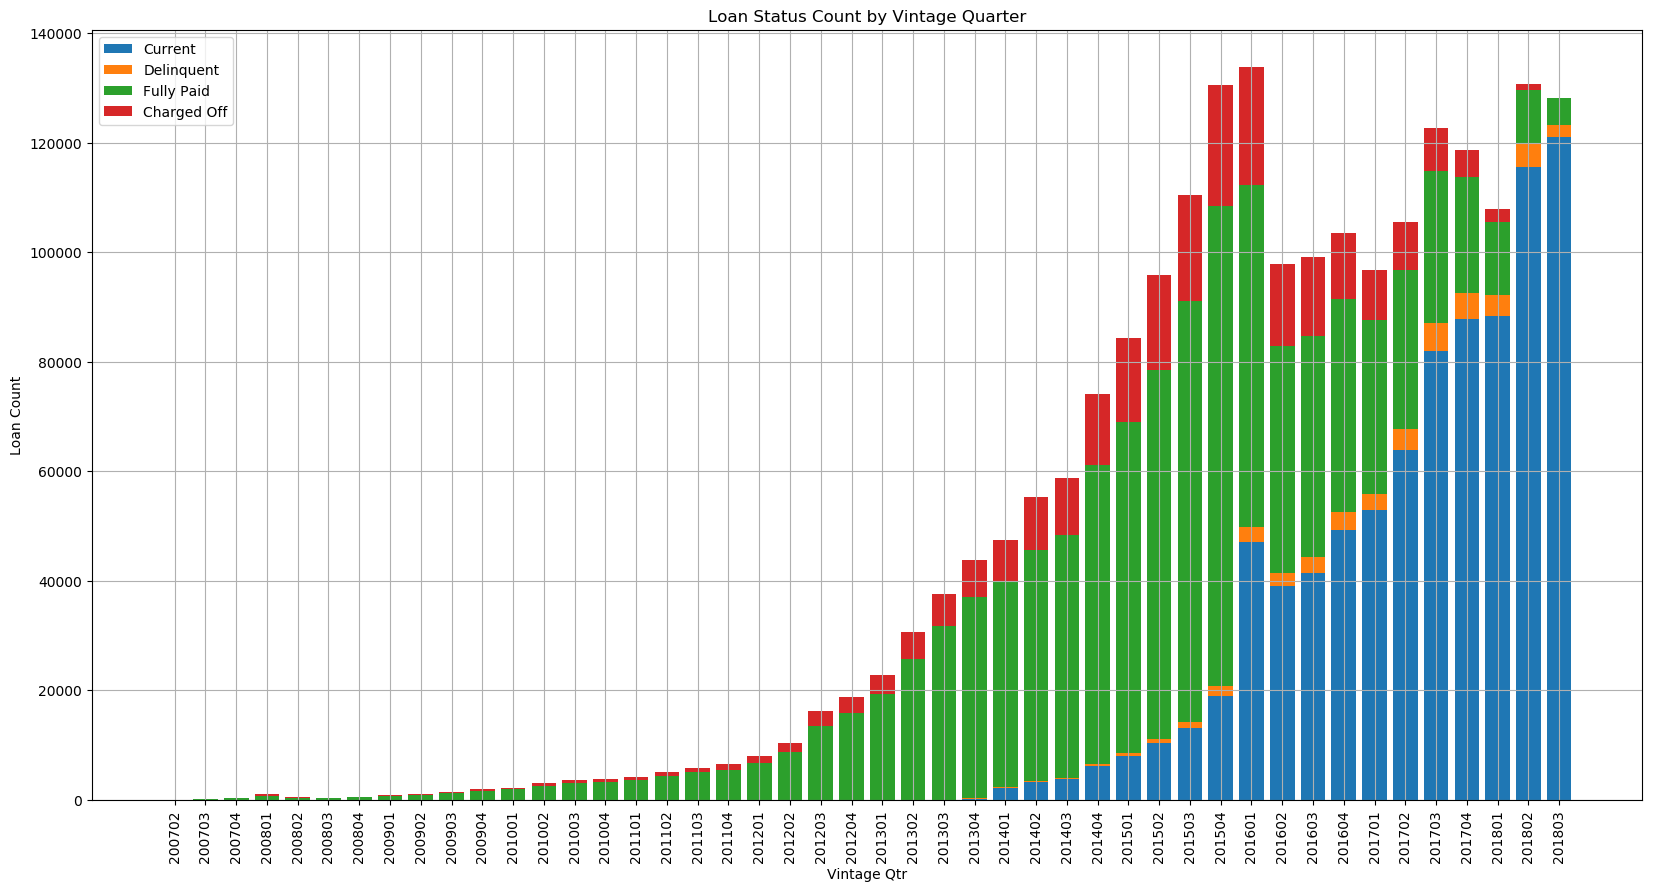

In [22]:
# with plt.style.context(('seaborn-poster')):
with plt.style.context(('default')):    
    
    plt.figure(figsize = (20, 10))
    series_labels = ['Current', 'Delinquent', 'Fully Paid', 'Charged Off']
    data = [list_Qtr_Cu, list_Qtr_DQ, list_Qtr_FP, list_Qtr_CO]
    category_labels = list_Qtr_dates

    stacked_bar(data,
                series_labels,
                category_labels = category_labels,
                show_values = False, 
                value_format = "{:.2f}",
                y_label = "Loan Count",
                x_label = 'Vintage Qtr',
                ch_title = 'Loan Status Count by Vintage Quarter')

    plt.savefig('bar_qtr1.png')    
plt.show();

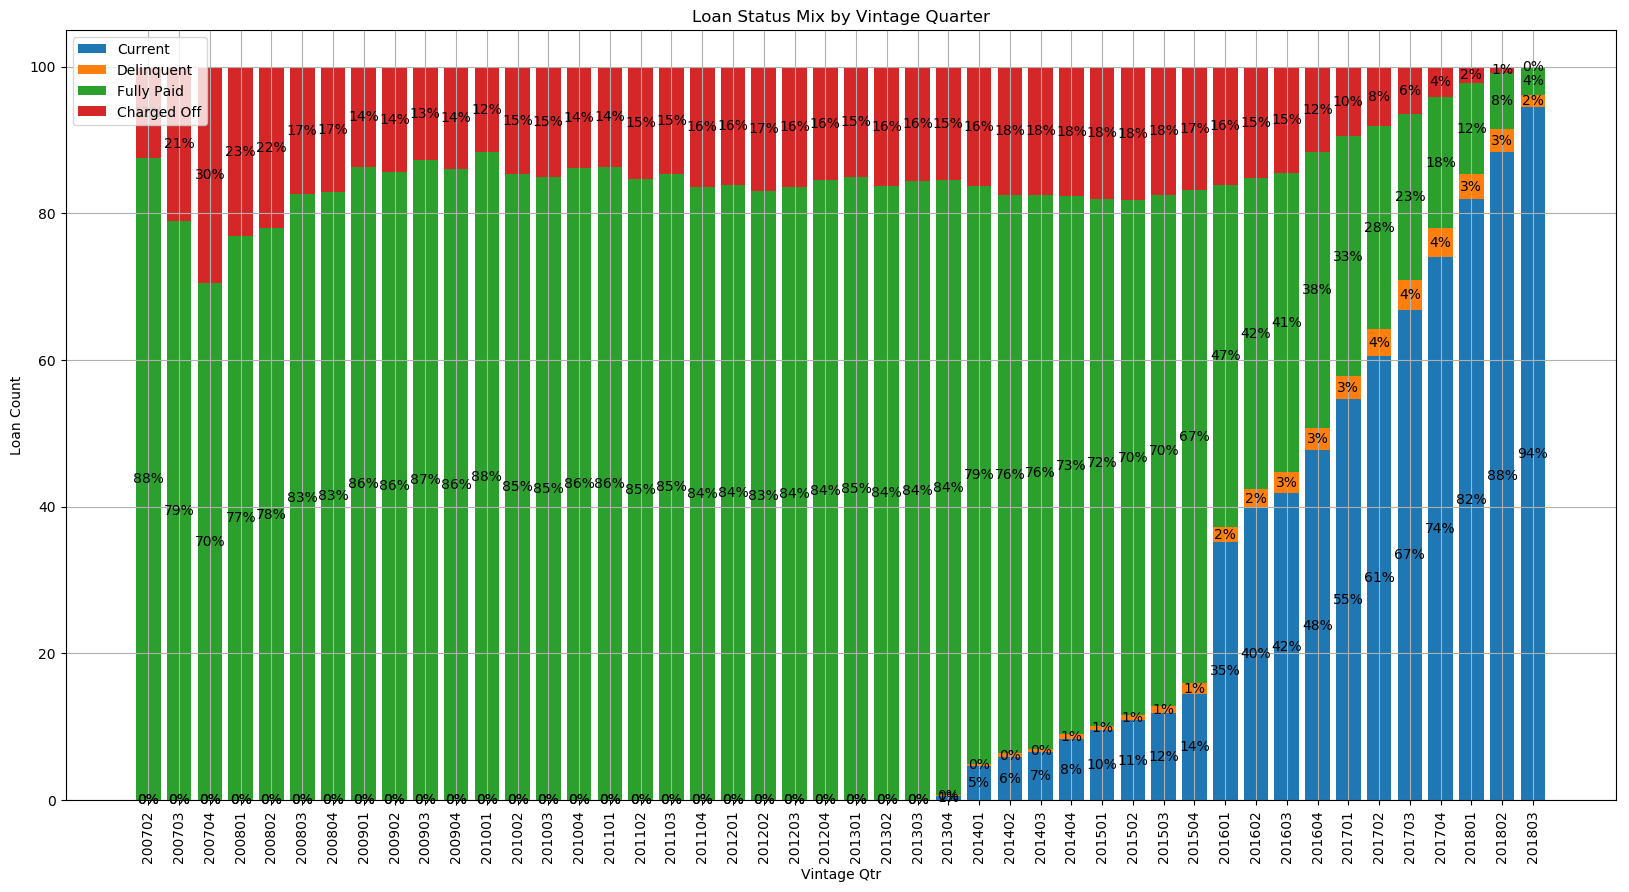

In [23]:
# with plt.style.context(('seaborn-poster')):
with plt.style.context(('default')):
    
    plt.figure(figsize = (20, 10))
    series_labels = ['Current', 'Delinquent', 'Fully Paid', 'Charged Off']
    data = [list_Qtr_Cu_pct, list_Qtr_DQ_pct, list_Qtr_FP_pct, list_Qtr_CO_pct]
    category_labels = list_Qtr_dates

    stacked_bar(data,
                series_labels,
                category_labels = category_labels,
                show_values = True,
                value_format = "{0:.0f}%", 
                y_label = "Loan Count",
                x_label = 'Vintage Qtr',
                ch_title = 'Loan Status Mix by Vintage Quarter')

    plt.savefig('bar_qtr2.png')
plt.show();

### Subset the Data
* Now that we have a good feel for the data, we see that prior to 2013, there wasn't a whole lot of originations.  Also, after 2014 the loan status begins to skew towards "Current".  We don't want early payoff / charge offs affecting our ROA predictions so we subset to the below:
    * Loans funded between Q1 2012 and Q4 2014.
    * We'll keep 2015 Q1 loans as an "Out of Time" period when assessing models.
    * Only loans in "Fully Paid" or "Charged Off" status.

In [24]:
## Isolate to only matured loans & Vintages between 201201 and 201503
df = df[(df['loan_status'] == 'Fully Paid') | (df['loan_status'] == 'Charged Off')]
df = df[(df['YearMonth'] >= '201201') & (df['YearMonth'] < '201504')]

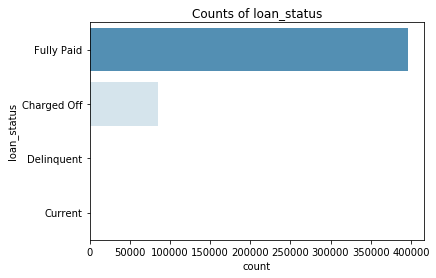

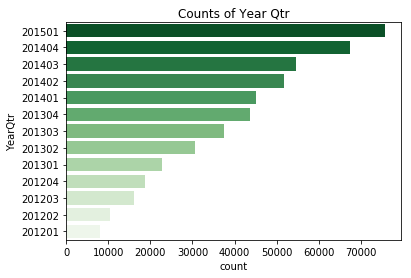

In [25]:
countplotshorizontal(frame = df, field = 'loan_status', title = "Counts of " + 'loan_status', ylabel = 'loan_status', palette = "RdBu_r")
countplotshorizontal(frame = df, field = 'YearQtr', title = "Counts of " + 'Year Qtr', ylabel = 'YearQtr', palette = "Greens_r")

In [26]:
dfTemp1 = pd.DataFrame(df.groupby(['issue_d', 'loan_status'], axis = 0)['count'].sum())
dfTemp1 = dfTemp1.reset_index(level = 'issue_d', col_level = 0)
dfTemp1 = dfTemp1.reset_index(level = 'loan_status', col_level = 0)

dfTemp2 = pd.DataFrame(df.groupby(['issue_d'], axis = 0)['count'].sum())
dfTemp2['loan_status'] = 'total'
dfTemp2 = dfTemp2.reset_index(level = 'issue_d', col_level = 0)

dfTemp3 = pd.merge(dfTemp1, dfTemp2, how = 'left', left_on = 'issue_d', right_on = 'issue_d', copy = True)
del dfTemp3['loan_status_y']

dfTemp3 = dfTemp3.rename(columns = {'loan_status_x': 'loan_status', 'count_x': 'count', 'count_y': 'total', 'issue_d': 'date'})
dfTemp3['pct'] = dfTemp3['count'] / dfTemp3['total']
dfTemp3 = dfTemp3.loc[dfTemp3['loan_status'] == 'Charged Off']
dfTemp3 = dfTemp3.set_index('date')

dfTemp4 = dfTemp3.reset_index(drop = False)

# Convert to String
dfTemp4['date2'] = dfTemp4['date'].apply(lambda x: x.strftime('%m%Y'))
dfTemp4['Month'] = dfTemp4['date2'].str[0:2]
dfTemp4['Year'] = dfTemp4['date2'].str[2:6]

dfTemp4['YearMonth'] = dfTemp4['Year'] + dfTemp4['Month']

dfTemp4[0:5]

date  loan_status  count  total   pct   date2 Month  Year YearMonth
0 2012-01-01  Charged Off  440    2602  0.169  012012  01    2012  201201  
1 2012-02-01  Charged Off  421    2560  0.164  022012  02    2012  201202  
2 2012-03-01  Charged Off  443    2914  0.152  032012  03    2012  201203  
3 2012-04-01  Charged Off  496    3230  0.154  042012  04    2012  201204  
4 2012-05-01  Charged Off  569    3400  0.167  052012  05    2012  201205

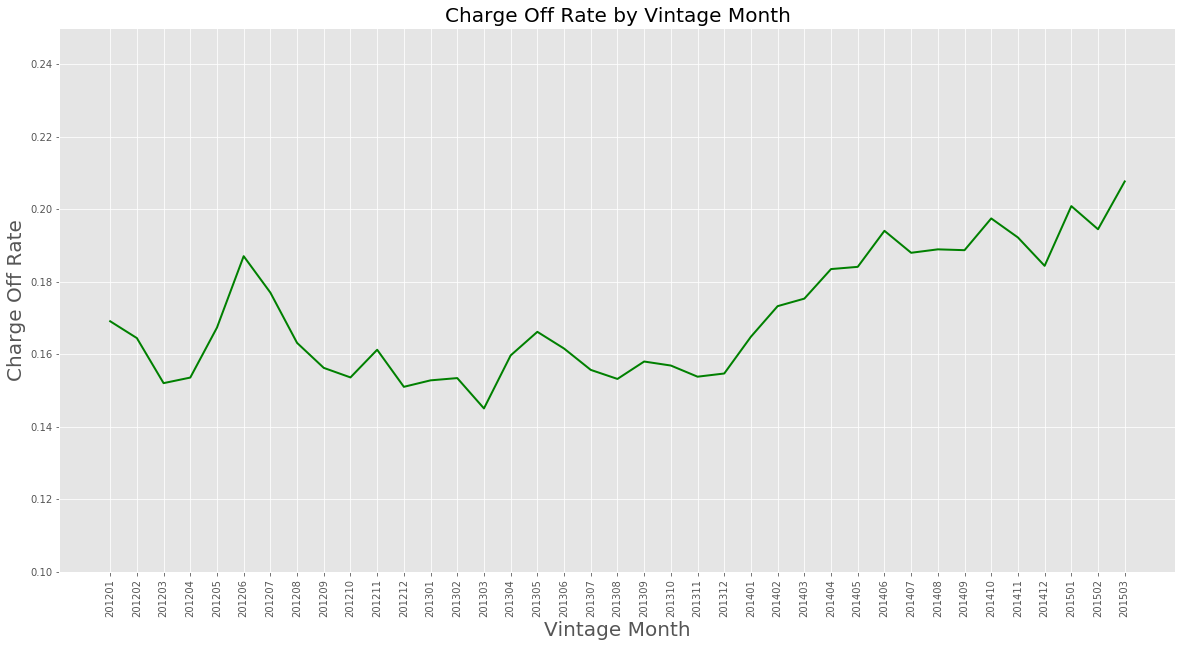

In [27]:
with plt.style.context(('ggplot')):
# with plt.style.context(('seaborn-poster')):
# with plt.style.context(('default')):

    fig = plt.figure(figsize = (20,10))
    ax = plt.axes()

    ax.plot(dfTemp4['YearMonth'], dfTemp4['pct'], 'g-', lw = 2.0)

    plt.title("Charge Off Rate by Vintage Month", fontsize = 20)
    plt.xlabel("Vintage Month", fontsize = 20)
    plt.ylabel("Charge Off Rate", fontsize = 20)
    plt.ylim(.10, .25)
    plt.xticks(rotation = 'vertical')

plt.show()

#### Maybe try splitting by Vintage Month by Grade to see if shift has occured.

In [28]:
## Group By Quarter

df_Qtr1 = pd.DataFrame(df.groupby(['YearQtr', 'grade'], axis = 0)['count'].sum())
df_Qtr1 = df_Qtr1.reset_index(level = 'YearQtr', col_level = 0)
df_Qtr1 = df_Qtr1.reset_index(level = 'grade', col_level = 0)

df_Qtr2 = pd.DataFrame(df.groupby(['YearQtr'], axis = 0)['count'].sum())
df_Qtr2['grade'] = 'total'
df_Qtr2 = df_Qtr2.reset_index(level = 'YearQtr', col_level = 0)

df_Qtr3 = pd.merge(df_Qtr1, df_Qtr2, how = 'left', left_on = 'YearQtr', right_on = 'YearQtr', copy = True)
del df_Qtr3['grade_y']

df_Qtr3 = df_Qtr3.rename(columns = {'grade_x': 'grade', 'count_x': 'count', 'count_y': 'total'})
df_Qtr3['pct'] = (df_Qtr3['count'] / df_Qtr3['total']) * 100
# df_Qtr3 = df_Qtr3.loc[dfTemp3['loan_status'] == 'Charged Off']
df_Qtr3 = df_Qtr3.set_index('YearQtr')

df_Qtr4 = df_Qtr3.reset_index(drop = False)

display(HTML(df_Qtr4[0:10].to_html()))
display(HTML(df_Qtr4[-8:].to_html()))

In [29]:
## Create Lists for Graphing

df_Qtr_srs = df_Qtr4['YearQtr'].unique()
minQtr = min(df_Qtr_srs)
maxQtr = max(df_Qtr_srs)
df_Qtr_Date = df_Qtr_Date.loc[(df_Qtr_Date['YearQtr'] >= minQtr) & (df_Qtr_Date['YearQtr'] <= maxQtr)]

df_Qtr_A = df_Qtr4[(df_Qtr4['grade'] == 'A')]
df_Qtr_A = pd.merge(df_Qtr_Date, df_Qtr_A, how = 'left', left_on = 'YearQtr', right_on = 'YearQtr', copy = False)
df_Qtr_B = df_Qtr4[(df_Qtr4['grade'] == 'B')]
df_Qtr_B = pd.merge(df_Qtr_Date, df_Qtr_B, how = 'left', left_on = 'YearQtr', right_on = 'YearQtr', copy = False)
df_Qtr_C = df_Qtr4[(df_Qtr4['grade'] == 'C')]
df_Qtr_C = pd.merge(df_Qtr_Date, df_Qtr_C, how = 'left', left_on = 'YearQtr', right_on = 'YearQtr', copy = False)
df_Qtr_D = df_Qtr4[(df_Qtr4['grade'] == 'D')]
df_Qtr_D = pd.merge(df_Qtr_Date, df_Qtr_D, how = 'left', left_on = 'YearQtr', right_on = 'YearQtr', copy = False)
df_Qtr_E = df_Qtr4[(df_Qtr4['grade'] == 'E')]
df_Qtr_E = pd.merge(df_Qtr_Date, df_Qtr_E, how = 'left', left_on = 'YearQtr', right_on = 'YearQtr', copy = False)
df_Qtr_F = df_Qtr4[(df_Qtr4['grade'] == 'F')]
df_Qtr_F = pd.merge(df_Qtr_Date, df_Qtr_F, how = 'left', left_on = 'YearQtr', right_on = 'YearQtr', copy = False)
df_Qtr_G = df_Qtr4[(df_Qtr4['grade'] == 'G')]
df_Qtr_G = pd.merge(df_Qtr_Date, df_Qtr_G, how = 'left', left_on = 'YearQtr', right_on = 'YearQtr', copy = False)

list_Qtr_dates = df_Qtr_Date['YearQtr'].tolist()

list_Qtr_A = df_Qtr_A['count'].fillna(0).astype(int).tolist()
list_Qtr_B = df_Qtr_B['count'].fillna(0).astype(int).tolist()
list_Qtr_C = df_Qtr_C['count'].fillna(0).astype(int).tolist()
list_Qtr_D = df_Qtr_D['count'].fillna(0).astype(int).tolist()
list_Qtr_E = df_Qtr_E['count'].fillna(0).astype(int).tolist()
list_Qtr_F = df_Qtr_F['count'].fillna(0).astype(int).tolist()
list_Qtr_G = df_Qtr_G['count'].fillna(0).astype(int).tolist()

list_Qtr_A_pct = df_Qtr_A['pct'].fillna(0.0).tolist()
list_Qtr_B_pct = df_Qtr_B['pct'].fillna(0.0).tolist()
list_Qtr_C_pct = df_Qtr_C['pct'].fillna(0.0).tolist()
list_Qtr_D_pct = df_Qtr_D['pct'].fillna(0.0).tolist()
list_Qtr_E_pct = df_Qtr_E['pct'].fillna(0.0).tolist()
list_Qtr_F_pct = df_Qtr_F['pct'].fillna(0.0).tolist()
list_Qtr_G_pct = df_Qtr_G['pct'].fillna(0.0).tolist()

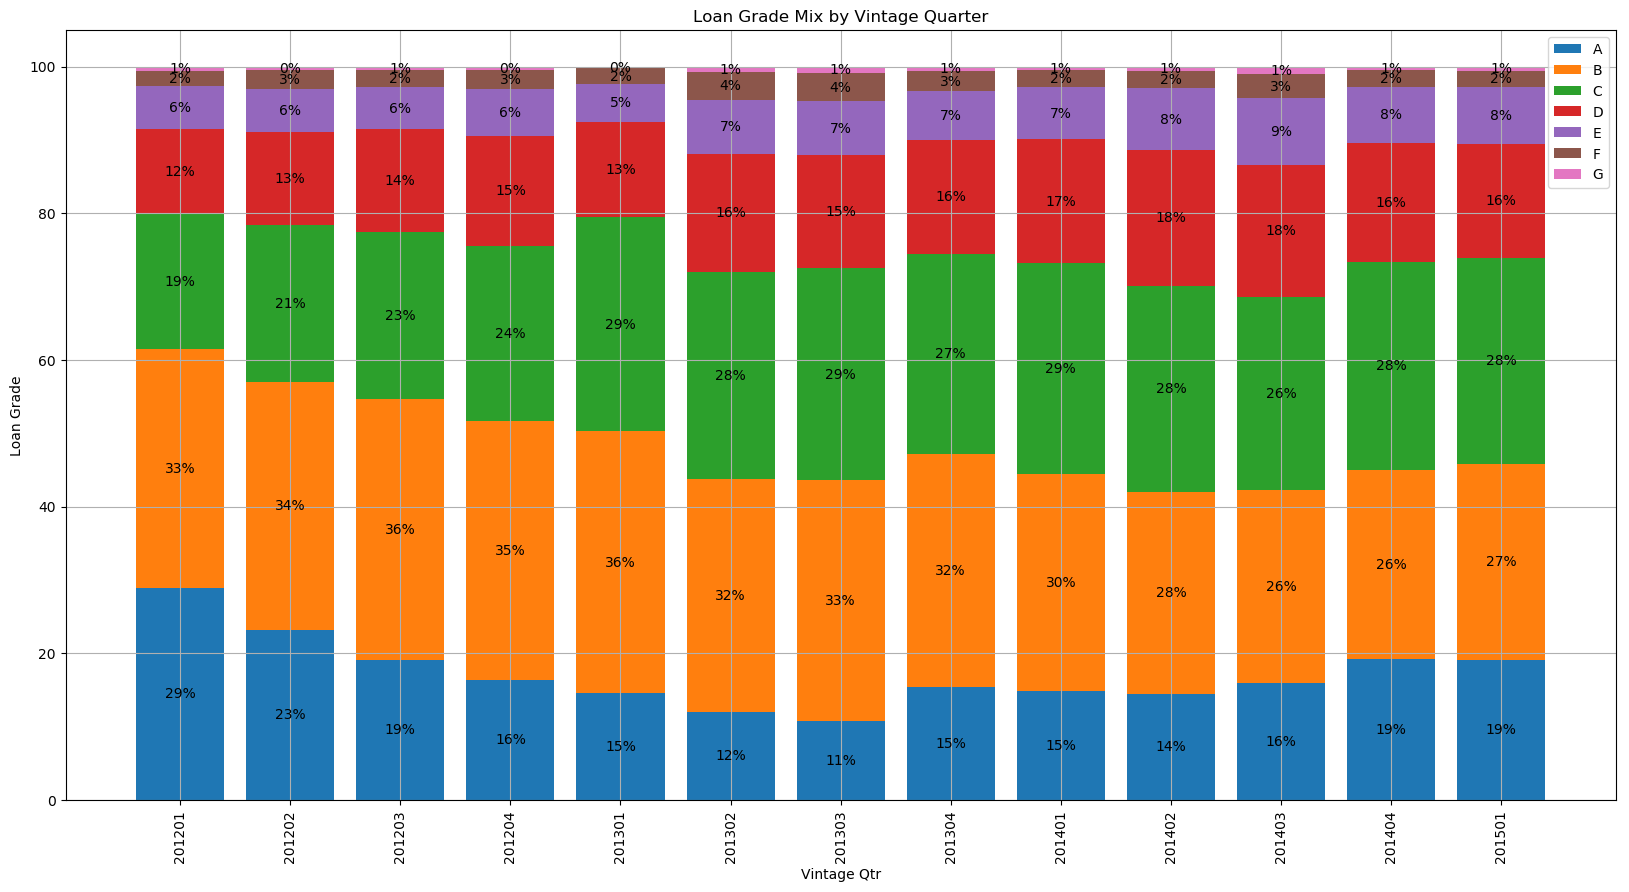

In [30]:
# with plt.style.context(('seaborn-poster')):
with plt.style.context(('default')):
    
    plt.figure(figsize = (20, 10))
    series_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
    data = [list_Qtr_A_pct, list_Qtr_B_pct, list_Qtr_C_pct, list_Qtr_D_pct, list_Qtr_E_pct, list_Qtr_F_pct, list_Qtr_G_pct]
    category_labels = list_Qtr_dates

    stacked_bar(data,
                series_labels,
                category_labels = category_labels,
                show_values = True,
                value_format = "{0:.0f}%",
                y_label = "Loan Grade",
                x_label = 'Vintage Qtr',
                ch_title = 'Loan Grade Mix by Vintage Quarter')

    plt.savefig('bar_qtr3.png')
plt.show();

### Grade mix assessment
* From the above we see Lending Club shifted away from grade A and B loans around mid 2007 and into more C and D loans
* We also see there are relatively few E, F, and G loans. We should group these together.
* Since we have FICO we should also assess if the shift occured by FICO bands.

In [31]:
df['grade'] = np.where(df['grade'] == 'F', 'E', df['grade'])
df['grade'] = np.where(df['grade'] == 'G', 'E', df['grade'])

df['fico_avg'] = (df['fico_range_low'] + df['fico_range_high']) / 2
df['fico_avg'].quantile([.1, .2, .4, .6, .8, .9])
FICO_bins = [0, 681, 697, 717, 737, 1000]
FICO_names = ['<= 681', '682 to 697', '698 to 717', '718 to 737', '738+']
df['fico_bin'] = pd.cut(df['fico_avg'], FICO_bins, labels = FICO_names)

In [32]:
## Group By Quarter

df_Qtr1 = pd.DataFrame(df.groupby(['YearQtr', 'fico_bin'], axis = 0)['count'].sum())
df_Qtr1 = df_Qtr1.reset_index(level = 'YearQtr', col_level = 0)
df_Qtr1 = df_Qtr1.reset_index(level = 'fico_bin', col_level = 0)

df_Qtr2 = pd.DataFrame(df.groupby(['YearQtr'], axis = 0)['count'].sum())
df_Qtr2['fico_bin'] = 'total'
df_Qtr2 = df_Qtr2.reset_index(level = 'YearQtr', col_level = 0)

df_Qtr3 = pd.merge(df_Qtr1, df_Qtr2, how = 'left', left_on = 'YearQtr', right_on = 'YearQtr', copy = True)
del df_Qtr3['fico_bin_y']

df_Qtr3 = df_Qtr3.rename(columns = {'fico_bin_x': 'fico_bin', 'count_x': 'count', 'count_y': 'total'})
df_Qtr3['pct'] = (df_Qtr3['count'] / df_Qtr3['total']) * 100
# df_Qtr3 = df_Qtr3.loc[dfTemp3['loan_status'] == 'Charged Off']
df_Qtr3 = df_Qtr3.set_index('YearQtr')

df_Qtr4 = df_Qtr3.reset_index(drop = False)

display(HTML(df_Qtr4[0:10].to_html()))
display(HTML(df_Qtr4[-8:].to_html()))

In [33]:
## Create Lists for Graphing

df_Qtr_srs = df_Qtr4['YearQtr'].unique()
minQtr = min(df_Qtr_srs)
maxQtr = max(df_Qtr_srs)
df_Qtr_Date = df_Qtr_Date.loc[(df_Qtr_Date['YearQtr'] >= minQtr) & (df_Qtr_Date['YearQtr'] <= maxQtr)]

df_Qtr_A = df_Qtr4[(df_Qtr4['fico_bin'] == FICO_names[0])]
df_Qtr_A = pd.merge(df_Qtr_Date, df_Qtr_A, how = 'left', left_on = 'YearQtr', right_on = 'YearQtr', copy = False)

df_Qtr_B = df_Qtr4[(df_Qtr4['fico_bin'] == FICO_names[1])]
df_Qtr_B = pd.merge(df_Qtr_Date, df_Qtr_B, how = 'left', left_on = 'YearQtr', right_on = 'YearQtr', copy = False)

df_Qtr_C = df_Qtr4[(df_Qtr4['fico_bin'] == FICO_names[2])]
df_Qtr_C = pd.merge(df_Qtr_Date, df_Qtr_C, how = 'left', left_on = 'YearQtr', right_on = 'YearQtr', copy = False)

df_Qtr_D = df_Qtr4[(df_Qtr4['fico_bin'] == FICO_names[3])]
df_Qtr_D = pd.merge(df_Qtr_Date, df_Qtr_D, how = 'left', left_on = 'YearQtr', right_on = 'YearQtr', copy = False)

df_Qtr_E = df_Qtr4[(df_Qtr4['fico_bin'] == FICO_names[4])]
df_Qtr_E = pd.merge(df_Qtr_Date, df_Qtr_E, how = 'left', left_on = 'YearQtr', right_on = 'YearQtr', copy = False)

list_Qtr_dates = df_Qtr_Date['YearQtr'].tolist()

list_Qtr_A = df_Qtr_A['count'].fillna(0).astype(int).tolist()
list_Qtr_B = df_Qtr_B['count'].fillna(0).astype(int).tolist()
list_Qtr_C = df_Qtr_C['count'].fillna(0).astype(int).tolist()
list_Qtr_D = df_Qtr_D['count'].fillna(0).astype(int).tolist()
list_Qtr_E = df_Qtr_E['count'].fillna(0).astype(int).tolist()

list_Qtr_A_pct = df_Qtr_A['pct'].fillna(0.0).tolist()
list_Qtr_B_pct = df_Qtr_B['pct'].fillna(0.0).tolist()
list_Qtr_C_pct = df_Qtr_C['pct'].fillna(0.0).tolist()
list_Qtr_D_pct = df_Qtr_D['pct'].fillna(0.0).tolist()
list_Qtr_E_pct = df_Qtr_E['pct'].fillna(0.0).tolist()

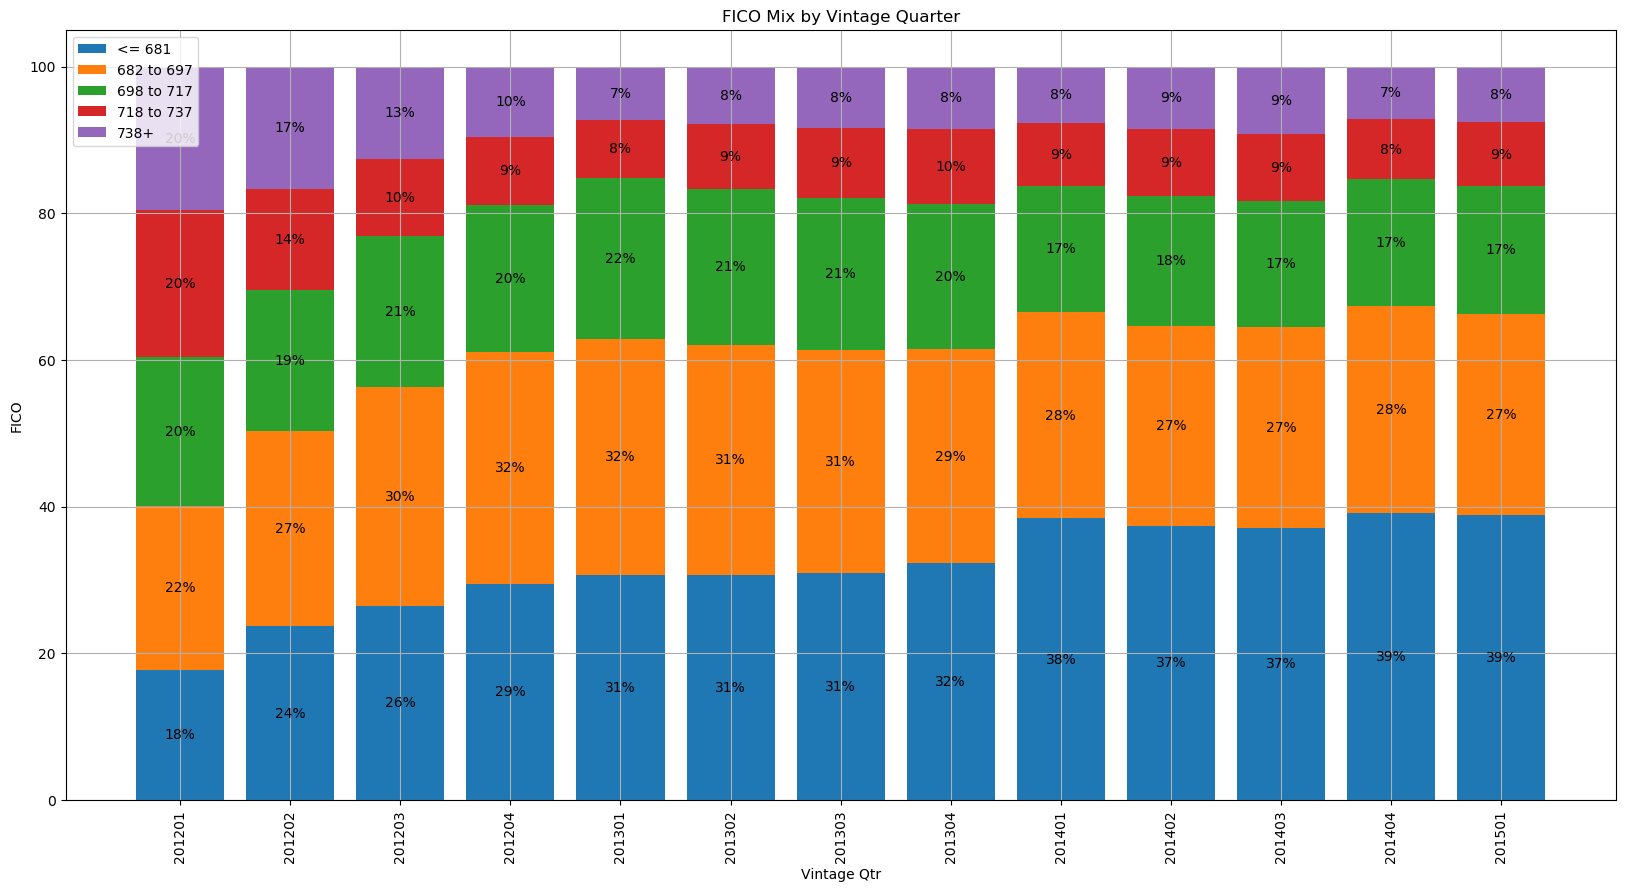

In [34]:
# with plt.style.context(('seaborn-poster')):
with plt.style.context(('default')):
    
    plt.figure(figsize = (20, 10))
    series_labels = FICO_names
    data = [list_Qtr_A_pct, list_Qtr_B_pct, list_Qtr_C_pct, list_Qtr_D_pct, list_Qtr_E_pct]
    category_labels = list_Qtr_dates

    stacked_bar(data,
                series_labels,
                category_labels = category_labels,
                show_values = True, 
                value_format = "{0:.0f}%",
                y_label = "FICO",
                x_label = 'Vintage Qtr',
                ch_title = 'FICO Mix by Vintage Quarter')

    plt.savefig('bar_qtr4.png')
plt.show();

### Seeing the FICO shift above, further sub segmentation is likely needed.  We'll remove loans funded in 2012 and just train on 2013 and 2014.

In [35]:
df = df[(df['YearMonth'] >= '201301')]

In [36]:
# Save the DataFrame
df.to_pickle('df1.pkl')

In [37]:
# Read Back in the DataFrame
df = pd.read_pickle('df1.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 429387 entries, 0 to 421094
Columns: 159 entries, id to fico_bin
dtypes: category(3), datetime64[ns](4), float64(112), int64(1), object(39)
memory usage: 515.6+ MB


#### Check Missing Values

In [38]:
# Missing values statistics
miss_values = null_values(df)
display(HTML(miss_values.to_html()))

miss_values.to_csv('miss_values.csv', sep = ',', encoding = 'utf-8')

Dataframe has 159 columns.
There are 72 columns that have missing values.


### Get Rid of Columns Missing > 50% of Values

In [39]:
missings = [i for i in df.count() < len(df) * 0.50]
df.drop(df.columns[missings], axis = 1, inplace = True)

In [40]:
miss_values = null_values(df)
display(HTML(miss_values.to_html()))

Dataframe has 102 columns.
There are 15 columns that have missing values.


#### We have a lot of objects, let's check the number of unique values for 'object' columns
* There are likely too many emp_title categories to model off of so we delete those
* Also, we don't need the file column anymore

In [41]:
display(df.select_dtypes('object').apply(pd.Series.nunique, axis = 0))

del df['emp_title']
del df['title']
del df['file']

id                      429387
term                    2     
int_rate                160   
grade                   5     
sub_grade               35    
emp_title               164860
emp_length              11    
home_ownership          4     
verification_status     3     
pymnt_plan              1     
purpose                 13    
title                   33274 
zip_code                886   
addr_state              50    
revol_util              1193  
initial_list_status     2     
application_type        1     
hardship_flag           1     
disbursement_method     1     
debt_settlement_flag    2     
file                    3     
str_date                27    
Year                    3     
Month                   12    
YearMonth               27    
Qtr                     4     
dtype: int64

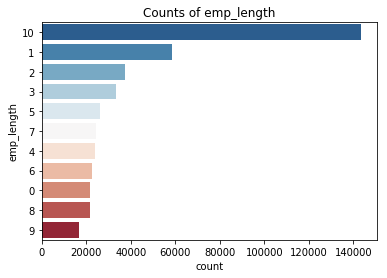

In [42]:
df['emp_length'].fillna(value = 0, inplace = True)
df['emp_length'].replace(to_replace='[^0-9]+', value = '', inplace = True, regex = True)

countplotshorizontal(frame = df, field = 'emp_length', title = "Counts of " + 'emp_length', ylabel = 'emp_length', palette = "RdBu_r")

### Next we do some data conversions and calculate the ROA
* First let's explore the definitions of some of these variables in the Data

In [43]:
display(HTML(df[0:1000].to_html()))

In [44]:
pd.set_option('display.max_colwidth', -1)

DictList = ['last_fico_range_high','verification_status','total_rec_late_fee','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','bcOpenToBuy','bcUtil','mo_sin_old_il_acct',
            'num_tl_30dpd','pct_tl_nvr_dlq']
DataDict.loc[DataDict['Variable'].isin(DictList)]

Variable  \
37   last_fico_range_high   
45   mo_sin_old_il_acct     
70   num_tl_30dpd           
82   pct_tl_nvr_dlq         
105  total_pymnt            
106  total_pymnt_inv        
107  total_rec_int          
108  total_rec_late_fee     
109  total_rec_prncp        
112  verification_status    
9    bcOpenToBuy            
10   bcUtil                 
69   num_tl_30dpd           
79   pct_tl_nvr_dlq         

                                                                                    Description  
37   The upper boundary range the borrower’s last FICO pulled belongs to.                        
45   Months since oldest bank installment account opened                                         
70   Number of accounts currently 30 days past due (updated in past 2 months)                    
82   Percent of trades never delinquent                                                          
105  Payments received to date for total amount funded                                           
106  Payments received to date for portion of total amount funded by investors                   
107  Interest received to date                                                                   
108  Late fees received to date                                                                  
109  Principal received to date                                                                  
112  Indicates if income was verified by LC, not verified, or if the income source was verified  
9    Total open to buy on revolving bankcards.                                                   
10   Ratio of total current balance to high credit/credit limit for all bankcard accounts.       
69   Number of accounts currently 30 days past due (updated in past 2 months)                    
79   Percent of trades never delinquent

### Convert Some Variables to INT32

In [45]:
IntList = ['loan_amnt','funded_amnt','funded_amnt_inv','annual_inc','delinq_2yrs','fico_range_low','fico_range_high','inq_last_6mths','open_acc','pub_rec','revol_bal','total_acc',
           'out_prncp','out_prncp_inv','last_fico_range_high','last_fico_range_low','collections_12_mths_ex_med','policy_code','acc_now_delinq','tot_coll_amt','tot_cur_bal',
           'total_rev_hi_lim','acc_open_past_24mths','avg_cur_bal','bc_open_to_buy','chargeoff_within_12_mths','delinq_amnt','mo_sin_old_il_acct','mo_sin_old_rev_tl_op',
           'mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl','mort_acc','mths_since_recent_bc','mths_since_recent_inq','num_accts_ever_120_pd','num_actv_bc_tl','num_actv_rev_tl',
           'num_bc_sats','num_bc_tl','num_il_tl','num_op_rev_tl','num_rev_accts','num_rev_tl_bal_gt_0','num_sats','num_tl_120dpd_2m','num_tl_30dpd','num_tl_90g_dpd_24m',
           'num_tl_op_past_12m','pub_rec_bankruptcies','tax_liens','tot_hi_cred_lim','total_bal_ex_mort','total_bc_limit','total_il_high_credit_limit','emp_length']

for i in range(0,len(IntList)):
    if df[IntList[i]].dtype == 'object':
        df[IntList[i]] = df[IntList[i]]
    elif df[IntList[i]].dtype == 'float32':
        df[IntList[i]] = int(df[IntList[i]])
    elif df[IntList[i]].dtype == 'float64':
        df[IntList[i]] = df[IntList[i]].fillna(0).astype(np.int32)
    elif df[IntList[i]].dtype == 'int64':
        df[IntList[i]] = df[IntList[i]].fillna(0).astype(np.int32)
    elif df[IntList[i]].dtype == 'uint8':
        df[IntList[i]] = df[IntList[i]].fillna(0).astype(np.int32)
    elif df[IntList[i]].dtype == 'category':
        df[IntList[i]] = df[IntList[i]].fillna(0).astype(np.int32)
    else:
        df[IntList[i]] = df[IntList[i]]

### Intuitively there are some variables we don't need so below we delete them.

In [46]:
delList = ['funded_amnt_inv','out_prncp','out_prncp_inv','str_date','Year','Month','Qtr']
# delList2 = ['YearMonth','YearQtr']

for i in range(0, len(delList)):
    del df[delList[i]]

In [47]:
display(HTML(df[0:5].to_html()))

In [48]:
## CONVERT VARIABLE TYPES AND CALCULATE ROA

df['GCL'] = (df['total_pymnt'] + df['total_rec_late_fee']) - df['funded_amnt']
df['NCL'] = df['GCL'] - df['recoveries'] + df['collection_recovery_fee']

df['id'] = df['id'].fillna(0.0).astype(np.int64)
df['count'] = 1
df['funded_amnt'] = df['funded_amnt'].astype(np.float)
 
# converting to decimal interest rate format
df['int_rate'] = df['int_rate'].str.rstrip('%').astype('float')
df['revol_util'] = df['revol_util'].str.rstrip('%').astype('float')
df['dti'] = df['dti']
df['revol_util'] = df['revol_util']

# Convertint to int64
df['delinq_2yrs'] = df['delinq_2yrs'].astype(np.int64)
df['inq_last_6mths'] = df['inq_last_6mths'].astype(np.int64)
 
# Converting fields to integer / float where needed and fill in missing values with 0
df['revol_bal'] = df['revol_bal'].astype(np.float)
df['inq_last_6mths'] = df['inq_last_6mths'].astype(np.int64)
 
# Fill in missing last payment dates with issue date
df['replacement_d'] = df['issue_d'] + timedelta(days=30)
df['last_pymnt_d'].fillna(df['replacement_d'], inplace=True)
 
# Created fields will help with ROA calculation
df['time_in_file'] = (df['issue_d'] - df['earliest_cr_line']).dt.days / 365.25 * 12
df['term_int'] = df['term'].str[:3].astype(np.int64)
df['loan_end_date'] = df['issue_d'] + df['term_int'].values.astype("timedelta64[M]")
df['loan_end_date'] = pd.DatetimeIndex(df['loan_end_date']).normalize()
 
## Create ROA fields
df['life_of_loan'] = (df['last_pymnt_d'] - df['issue_d']).dt.days / 365.25 * 12
df['life_of_loan'] = np.where(df['life_of_loan'] < 12.0, 12.0, df['life_of_loan'])
df['life_of_loan_years'] = df['life_of_loan'] / 12.0
df['servicing_fee'] = df['total_pymnt'] * .01

## total_pymnt = Principal + Interest + Recoveries
df['total_rev'] = df['total_pymnt'] - df['funded_amnt'] - df['collection_recovery_fee'] - df['servicing_fee']
df['annual_rev'] = df['total_rev'] / (df['life_of_loan'] / 12)
df['roa'] = (df['annual_rev'] / df['funded_amnt']) * 100

In [49]:
pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x))
display(HTML(df[0:1000].to_html()))

In [50]:
pd.set_option('display.max_colwidth', -1)

DictList = ['initial_list_status']
DataDict.loc[DataDict['Variable'].isin(DictList)]

Variable  \
29  initial_list_status   

                                                           Description  
29  The initial listing status of the loan. Possible values are – W, F

In [51]:
# %%time

# CategoryList = ['grade','sub_grade','home_ownership','verification_status','loan_status','purpose','initial_list_status','application_type']

# f = pd.melt(df, id_vars = ['roa'], value_vars = CategoryList)
# g = sns.FacetGrid(f, col = "roa",  col_wrap = max(len(CategoryList), 5), sharex = False, sharey = False, height = 5)
# g = g.map(boxplot, "value", "roa")

### Anova Assessment

In [52]:
# %%time

# CategoryList = ['grade','sub_grade','home_ownership','verification_status','loan_status','purpose','initial_list_status','application_type']

# a = anova(frame = df, List = CategoryList, target = 'roa')

# a['disparity'] = np.log(1. / a['pval'].values)
# fig, ax = plt.subplots(figsize = (12, 8))
# sns.barplot(data = a, x = 'feature', y = 'disparity', ax = ax)
# x = plt.xticks(rotation = 90)

Text(0,0.5,'Data type')

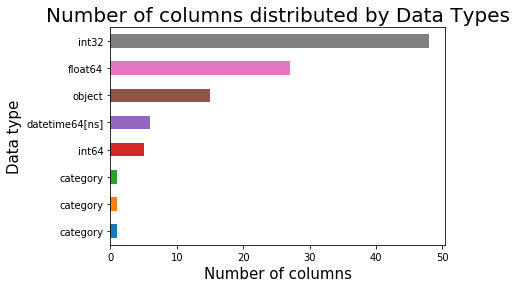

In [53]:
# Number of each type of column
df.dtypes.value_counts().sort_values().plot(kind = 'barh')
plt.title('Number of columns distributed by Data Types', fontsize = 20)
plt.xlabel('Number of columns', fontsize = 15)
plt.ylabel('Data type', fontsize = 15)

C:\Users\apost\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


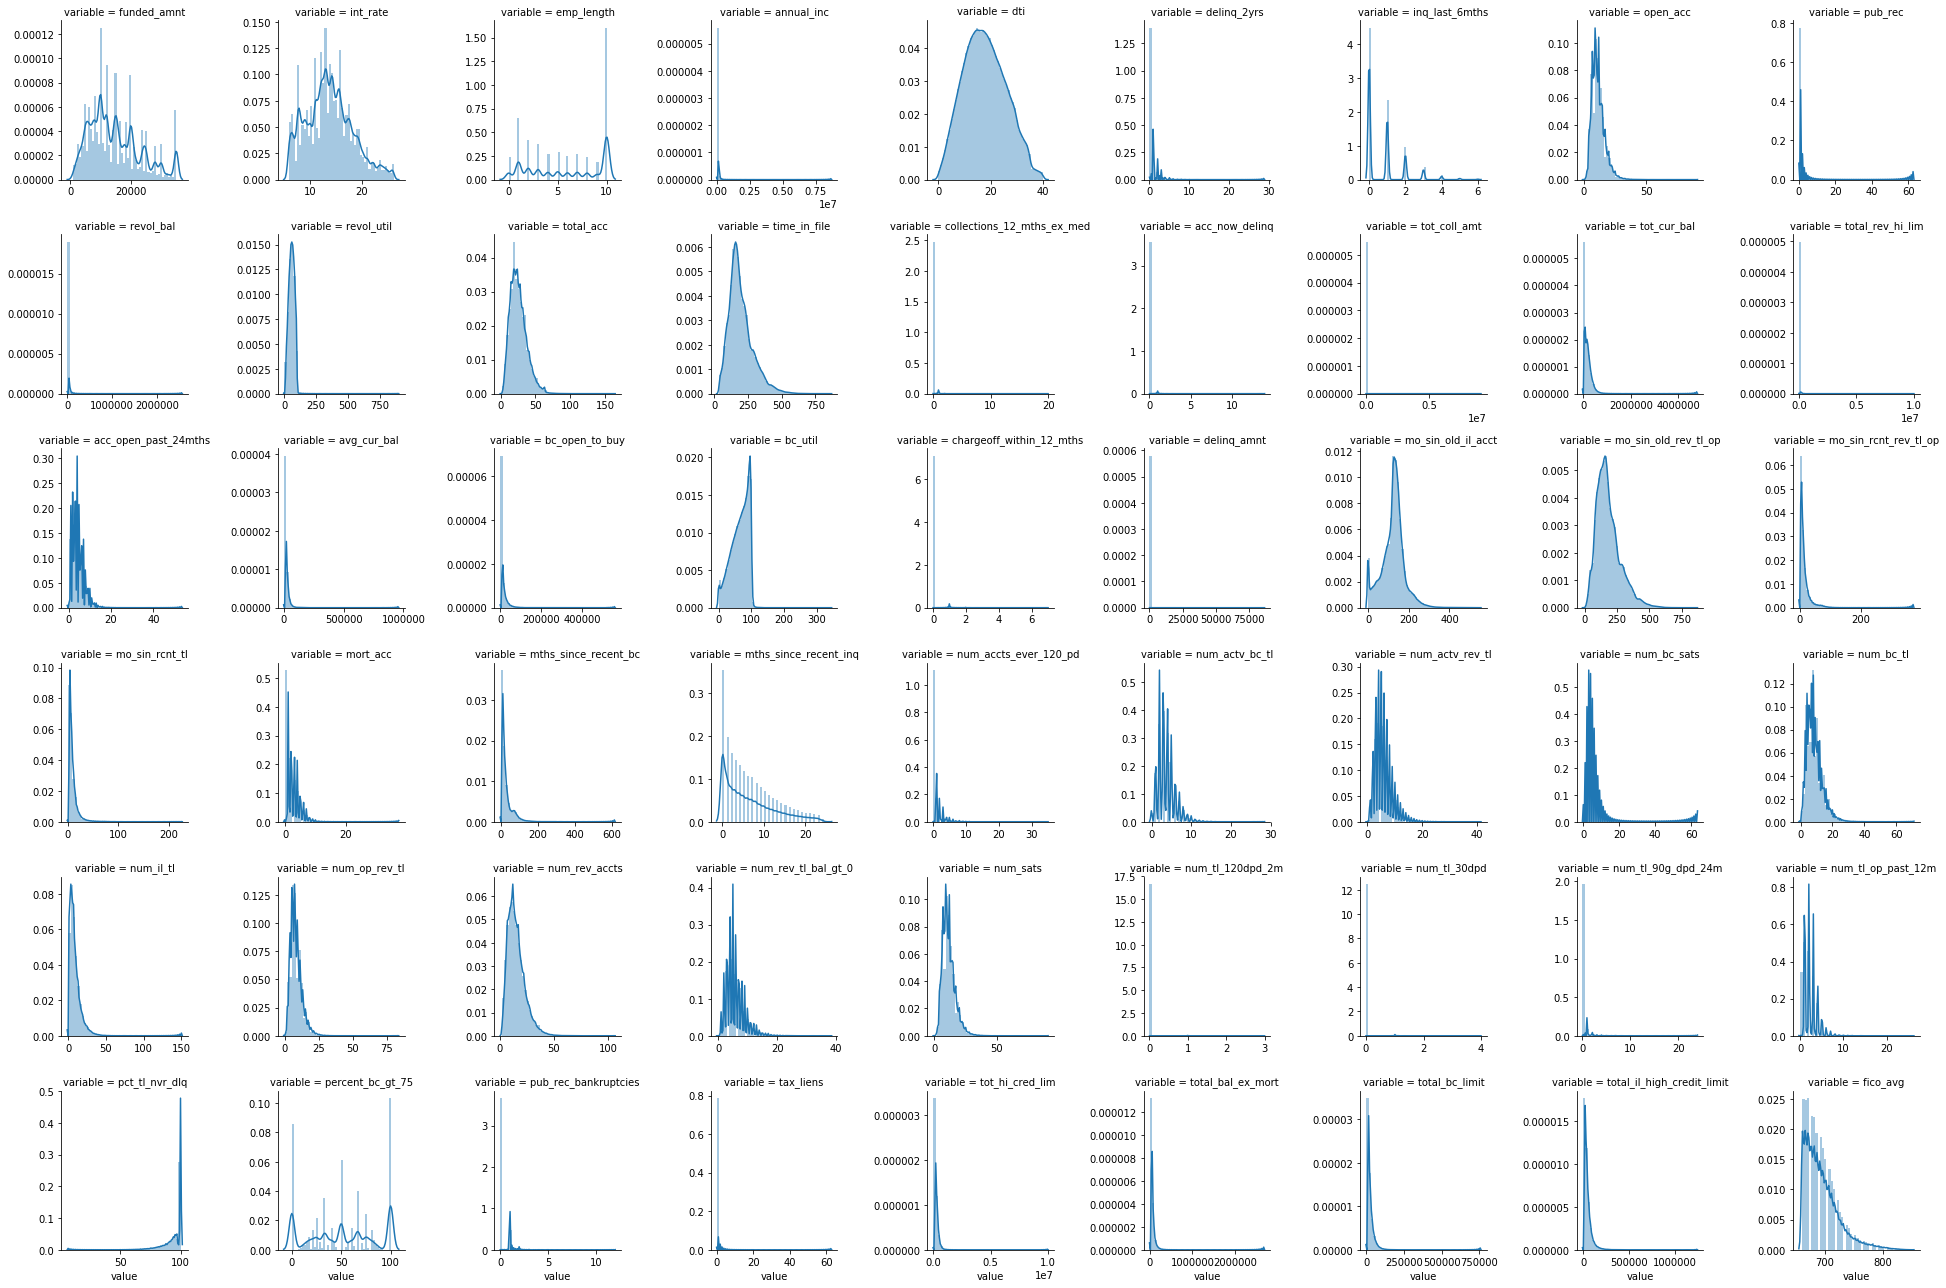

In [54]:
ContinuousList = ['funded_amnt','int_rate','emp_length','annual_inc','dti','delinq_2yrs','inq_last_6mths','open_acc','pub_rec','revol_bal','revol_util','total_acc','time_in_file',
                  'collections_12_mths_ex_med','acc_now_delinq','tot_coll_amt','tot_cur_bal','total_rev_hi_lim','acc_open_past_24mths','avg_cur_bal','bc_open_to_buy','bc_util',
                  'chargeoff_within_12_mths','delinq_amnt','mo_sin_old_il_acct','mo_sin_old_rev_tl_op','mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl','mort_acc','mths_since_recent_bc',
                  'mths_since_recent_inq','num_accts_ever_120_pd','num_actv_bc_tl','num_actv_rev_tl','num_bc_sats','num_bc_tl','num_il_tl','num_op_rev_tl','num_rev_accts',
                  'num_rev_tl_bal_gt_0','num_sats','num_tl_120dpd_2m','num_tl_30dpd','num_tl_90g_dpd_24m','num_tl_op_past_12m','pct_tl_nvr_dlq','percent_bc_gt_75','pub_rec_bankruptcies',
                  'tax_liens','tot_hi_cred_lim','total_bal_ex_mort','total_bc_limit','total_il_high_credit_limit','fico_avg']

f = pd.melt(df, value_vars = ContinuousList)
g = sns.FacetGrid(f, col = "variable",  col_wrap = 9, sharex = False, sharey = False)
g = g.map(sns.distplot, "value")

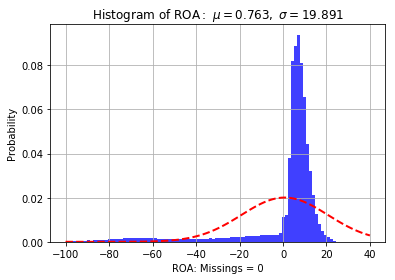

In [55]:
histogram(df['roa'], 'ROA', 'blue', 100)

In [56]:
pd.set_option('display.max_colwidth', -1)

DictList = ContinuousList
DataDict.loc[DataDict['Variable'].isin(DictList)]

Variable  \
0    acc_now_delinq               
1    acc_open_past_24mths         
4    annual_inc                   
7    avg_cur_bal                  
8    bc_open_to_buy               
9    bc_util                      
10   chargeoff_within_12_mths     
12   collections_12_mths_ex_med   
13   delinq_2yrs                  
14   delinq_amnt                  
16   dti                          
19   emp_length                   
23   funded_amnt                  
32   inq_last_6mths               
34   int_rate                     
45   mo_sin_old_il_acct           
46   mo_sin_old_rev_tl_op         
47   mo_sin_rcnt_rev_tl_op        
48   mo_sin_rcnt_tl               
49   mort_acc                     
54   mths_since_recent_bc         
56   mths_since_recent_inq        
59   num_accts_ever_120_pd        
60   num_actv_bc_tl               
61   num_actv_rev_tl              
62   num_bc_sats                  
63   num_bc_tl                    
64   num_il_tl                    
65   num_op_rev_tl                
66   num_rev_accts                
..             ...                
102  total_bc_limit               
104  total_il_high_credit_limit   
8    avg_cur_bal                  
11   chargeoff_within_12_mths     
12   collections_12_mths_ex_med   
17   dti                          
44   mo_sin_old_rev_tl_op         
45   mo_sin_rcnt_rev_tl_op        
46   mo_sin_rcnt_tl               
58   num_accts_ever_120_pd        
59   num_actv_bc_tl               
60   num_actv_rev_tl              
61   num_bc_sats                  
62   num_bc_tl                    
63   num_il_tl                    
64   num_op_rev_tl                
65   num_rev_accts                
66   num_rev_tl_bal_gt_0          
67   num_sats                     
68   num_tl_120dpd_2m             
69   num_tl_30dpd                 
70   num_tl_90g_dpd_24m           
71   num_tl_op_past_12m           
79   pct_tl_nvr_dlq               
81   pub_rec_bankruptcies         
90   tax_liens                    
93   tot_coll_amt                 
94   tot_cur_bal                  
95   tot_hi_cred_lim              
98   total_il_high_credit_limit   

                                                                                                                                                                                                  Description  
0    The number of accounts on which the borrower is now delinquent.                                                                                                                                           
1    Number of trades opened in past 24 months.                                                                                                                                                                
4    The self-reported annual income provided by the borrower during registration.                                                                                                                             
7    Average current balance of all accounts                                                                                                                                                                   
8    Total open to buy on revolving bankcards.                                                                                                                                                                 
9    Ratio of total current balance to high credit/credit limit for all bankcard accounts.                                                                                                                     
10   Number of charge-offs within 12 months                                                                                                                                                                    
12   Number of collections in 12 months excluding medical collections                                                                                                                       

In [57]:
df[['emp_length']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 429387 entries, 0 to 421094
Data columns (total 1 columns):
emp_length    429387 non-null int32
dtypes: int32(1)
memory usage: 14.9 MB


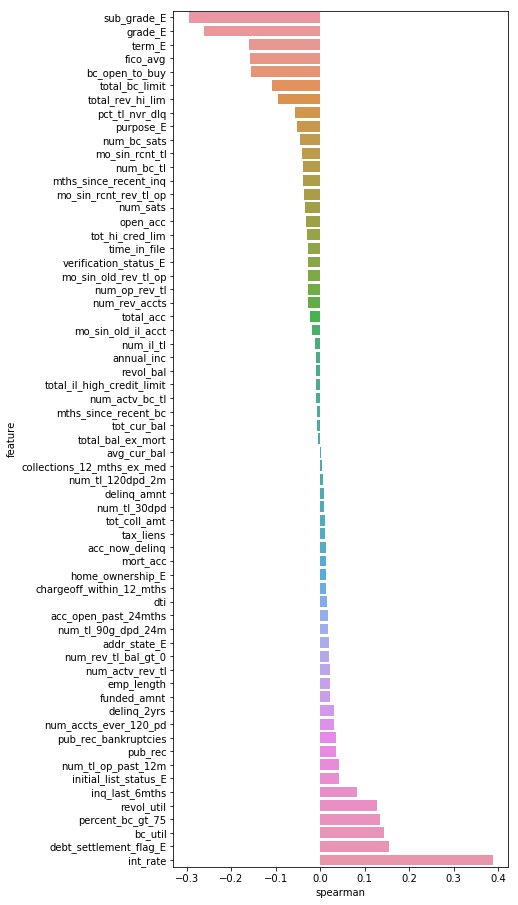

In [58]:
CategoricalList = ['term','grade','sub_grade','home_ownership','verification_status','purpose','addr_state','initial_list_status','debt_settlement_flag']

ContinuousList = ['funded_amnt','int_rate','emp_length','annual_inc','dti','delinq_2yrs','inq_last_6mths','open_acc','pub_rec','revol_bal','revol_util','total_acc','time_in_file',
                  'collections_12_mths_ex_med','acc_now_delinq','tot_coll_amt','tot_cur_bal','total_rev_hi_lim','acc_open_past_24mths','avg_cur_bal','bc_open_to_buy','bc_util',
                  'chargeoff_within_12_mths','delinq_amnt','mo_sin_old_il_acct','mo_sin_old_rev_tl_op','mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl','mort_acc','mths_since_recent_bc',
                  'mths_since_recent_inq','num_accts_ever_120_pd','num_actv_bc_tl','num_actv_rev_tl','num_bc_sats','num_bc_tl','num_il_tl','num_op_rev_tl','num_rev_accts',
                  'num_rev_tl_bal_gt_0','num_sats','num_tl_120dpd_2m','num_tl_30dpd','num_tl_90g_dpd_24m','num_tl_op_past_12m','pct_tl_nvr_dlq','percent_bc_gt_75','pub_rec_bankruptcies',
                  'tax_liens','tot_hi_cred_lim','total_bal_ex_mort','total_bc_limit','total_il_high_credit_limit','fico_avg']

cat_encoded = []

for c in CategoricalList:  
    encode(frame = df, feature = c, target = 'roa')
    cat_encoded.append(c + '_E')

features = ContinuousList + cat_encoded

df_spr = spearman_df(frame = df, features = features, target = 'roa')
spearman_chart(frame = df, features = features, target = 'roa')

In [59]:
# df_spr = spearman_df_abs(frame = df, features = features, target = 'roa')
# spearman_chart_abs(frame = df, features = features, target = 'roa')

In [60]:
pd.set_option('display.max_colwidth', -1)

DictList = ['grade','sub_grade','home_ownership','verification_status','purpose','initial_list_status','application_type','funded_amnt',
            'int_rate','annual_inc','dti','delinq_2yrs','inq_last_6mths','open_acc','pub_rec','revol_bal','revol_util','total_acc','time_in_file']
DataDict.loc[DataDict['Variable'].isin(DictList)]

Variable  \
4    annual_inc            
6    application_type      
13   delinq_2yrs           
16   dti                   
23   funded_amnt           
25   grade                 
26   home_ownership        
29   initial_list_status   
32   inq_last_6mths        
34   int_rate              
73   open_acc              
85   pub_rec               
87   purpose               
90   revol_bal             
91   revol_util            
92   sub_grade             
99   total_acc             
112  verification_status   
7    application_type      
17   dti                   
28   grade                 
83   purpose               

                                                                                                                                                                                                  Description  
4    The self-reported annual income provided by the borrower during registration.                                                                                                                             
6    Indicates whether the loan is an individual application or a joint application with two co-borrowers                                                                                                      
13   The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years                                                                                              
16   A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.  
23   The total amount committed to that loan at that point in time.                                                                                                                                            
25   LC assigned loan grade                                                                                                                                                                                    
26   The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER                                                     
29   The initial listing status of the loan. Possible values are – W, F                                                                                                                                        
32   The number of inquiries in past 6 months (excluding auto and mortgage inquiries)                                                                                                                          
34   Interest Rate on the loan                                                                                                                                                                                 
73   The number of open credit lines in the borrower's credit file.                                                                                                                                            
85   Number of derogatory public records                                                                                                                                                                       
87   A category provided by the borrower for the loan request.                                                                                                                                                 
90   Total credit revolving balance                                                                                                                                                                            
91   Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.                                                                                
92   LC assigned loan subgrade             

In [61]:
# Save the DataFrame
df.to_pickle('df2.pkl')

In [62]:
end_time = time.time()

diff = end_time - begin_time

print("run time ...", "\n")
print(diff, "seconds")
print(diff / 60, "minutes")
print(diff / 3600, "hours")

run time ... 

551.0 seconds
9.183333333333334 minutes
0.15305555555555556 hours
